---
# Tutorial Task: Sentiment-Based Quant Strategy
---

In this tutorial, you will design and implement a **quantitative trading strategy** that makes trading decisions based on **news sentiment** for a selected group of 5 stocks.

## Objective

Each day, over a 1-week historical period:
- **Buy** (go long) the stock with the **most positive** news sentiment
- **Sell** (go short) the stock with the **most negative** news sentiment

You will:
1. Select your own **universe of 3 stocks** (e.g., AAPL, MSFT, GOOGL).
2. Use the provided News API to retrieve articles for each stock.
3. Calculate the **average sentiment** for each stock daily using tools like `TextBlob`.
4. Track your portfolio’s value over time by simulating simple returns (real or mock).
5. Plot your portfolio value and analyze strategy performance.

## Constraints

- The News API is limited to **100 requests per day**. Avoid excessive API calls while developing by storing data or limiting requests.
- You only trade **one long and one short position** per day.
- Keep it simple: assume equal capital allocation to long and short trades.

## Deliverables

- A working Jupyter notebook implementing the above strategy
- Comments and clear structure for readability
- A final plot showing portfolio value over the 1-week period


## Step 1:
Import relevant libraries

In [6]:
# Data analysis
import pandas as pd
import numpy as np
# API calls
import requests
# Sentiment analysis
from textblob import TextBlob
# Time arithmetic
from datetime import datetime, timedelta
# Plotting
import matplotlib.pyplot as plt
# Financial data
import yfinance as yf

## Step 2:
Configure API

In [11]:
# Information to call API (variables capitalised to deonte constants)
API_KEY = '8dccb56c87484f47a9070502a94ba616'  # Replace with your actual key
BASE_URL = 'https://newsapi.org/v2/everything'
STOCK_UNIVERSE = ['AAPL']
START_DATE = datetime(2025, 5, 5)
END_DATE = datetime(2025, 5, 9)

## Step 3:
Create a function to get news and calculate the sentiment

In [12]:
# We use TextBlob() to calculate sentiment:

print(TextBlob("This stock is amazing!").sentiment.polarity)  # ➝ ~0.8 to 1.0 (positive)
print(TextBlob("This stock is okay.").sentiment.polarity)     # ➝ ~0.2 (slightly positive)
print(TextBlob("This stock is bad.").sentiment.polarity)      # ➝ ~-0.7 (negative)
print(TextBlob("This is a stock.").sentiment.polarity)    

0.7500000000000001
0.5
-0.6999999999999998
0.0


In [18]:
def get_sentiment(stock, date):
    from_date = date.strftime('%Y-%m-%d')
    to_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')

    params = {
        'q': stock,
        'from': from_date,
        'to': to_date,
        'sortBy': 'relevancy',
        'apiKey': API_KEY,
        'language': 'en',
        'pageSize': 10
    }

    # Call API with the relevant stock and dates
    response = requests.get(BASE_URL, params=params)
    data = response.json() # response in a .json format
    
    print(data)

    sentiments = []
    for article in data.get('articles', []):
        title = article.get('title', '')
        description = article.get('description', '')
        
        if not title and not description:
            continue  # skip if both are missing
        
        text = f"{title} {description}"
        # Get sentiment of text
        sentiment = TextBlob(text).sentiment.polarity
        sentiments.append(sentiment)

    if sentiments:
        mean = np.mean(sentiments)
        print(mean)
        return mean # return the mean sentiment of the stock over the day
    return 0.0

In [19]:
get_sentiment('AAPL', START_DATE)

{'status': 'ok', 'totalResults': 52, 'articles': [{'source': {'id': 'business-insider', 'name': 'Business Insider'}, 'author': 'wedwards@businessinsider.com (William Edwards)', 'title': 'BI Whale Watch: 9 stocks that investing legends like Warren Buffett are betting at least 20% of their portfolios on', 'description': "Warren Buffett is stepping down. Here's the one stock he's betting 28% of his portfolio on.", 'url': 'https://www.businessinsider.com/warren-buffett-stocks-top-investors-are-betting-on-whale-watch-2025-5', 'urlToImage': 'https://i.insider.com/6818f2683fe8d3928364f07e?width=921&format=jpeg', 'publishedAt': '2025-05-06T08:00:01Z', 'content': 'Warren Buffett, perhaps the greatest investor of all time, announced on Saturday that he would step down as CEO of Berkshire Hathaway at the end of the year.\r\nGiven the occasion, we thought it would … [+2779 chars]'}, {'source': {'id': None, 'name': '9to5Mac'}, 'author': 'Ben Lovejoy', 'title': 'Warren Buffett says Apple made Berksh

np.float64(0.16535948773448775)

## Step 4:
Simulate Trading

In [20]:
dates = pd.date_range(START_DATE, END_DATE)
strategy_returns = []
portfolio_value = 100000  # starting capital

for date in dates:
    print(f"Processing {date.strftime('%Y-%m-%d')}...")
    daily_sentiments = {}

    for stock in STOCK_UNIVERSE:
        try:
            sentiment = get_sentiment(stock, date)
            daily_sentiments[stock] = sentiment
        except Exception as e:
            print(f"Error retrieving news for {stock} on {date}: {e}")
            daily_sentiments[stock] = 0.0

    # pick long and short
    long_stock = max(daily_sentiments, key=daily_sentiments.get)
    short_stock = min(daily_sentiments, key=daily_sentiments.get)

    # Get market data from yfinance for both long and short
    next_day = date + pd.Timedelta(days=1)

    try:
        long_data = yf.download(long_stock, start=date.strftime('%Y-%m-%d'), end=next_day.strftime('%Y-%m-%d'), interval='1d')
        short_data = yf.download(short_stock, start=date.strftime('%Y-%m-%d'), end=next_day.strftime('%Y-%m-%d'), interval='1d')

    except:
        print(f"Issue with {long_stock} or {short_stock}")
        
    # Compute float returns from yfinance data
    if not long_data.empty and not short_data.empty:
        long_ret = (long_data['Close'].iloc[0] - long_data['Open'].iloc[0]) / long_data['Open'].iloc[0]
        short_ret = (short_data['Open'].iloc[0] - short_data['Close'].iloc[0]) / short_data['Open'].iloc[0]
        daily_ret = (long_ret + short_ret) / 2
        portfolio_value *= (1 + daily_ret)
    else:
        long_ret = 0.0
        short_ret = 0.0
        daily_ret = 0.0

    strategy_returns.append({
        'date': date,
        'long': long_stock,
        'short': short_stock,
        'long_return': long_ret,
        'short_return': short_ret,
        'daily_return': daily_ret,
        'portfolio_value': portfolio_value
    })


Processing 2025-05-05...
{'status': 'ok', 'totalResults': 52, 'articles': [{'source': {'id': 'business-insider', 'name': 'Business Insider'}, 'author': 'wedwards@businessinsider.com (William Edwards)', 'title': 'BI Whale Watch: 9 stocks that investing legends like Warren Buffett are betting at least 20% of their portfolios on', 'description': "Warren Buffett is stepping down. Here's the one stock he's betting 28% of his portfolio on.", 'url': 'https://www.businessinsider.com/warren-buffett-stocks-top-investors-are-betting-on-whale-watch-2025-5', 'urlToImage': 'https://i.insider.com/6818f2683fe8d3928364f07e?width=921&format=jpeg', 'publishedAt': '2025-05-06T08:00:01Z', 'content': 'Warren Buffett, perhaps the greatest investor of all time, announced on Saturday that he would step down as CEO of Berkshire Hathaway at the end of the year.\r\nGiven the occasion, we thought it would … [+2779 chars]'}, {'source': {'id': None, 'name': '9to5Mac'}, 'author': 'Ben Lovejoy', 'title': 'Warren Buffe

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Processing 2025-05-06...
{'status': 'ok', 'totalResults': 55, 'articles': [{'source': {'id': 'business-insider', 'name': 'Business Insider'}, 'author': 'wedwards@businessinsider.com (William Edwards)', 'title': 'BI Whale Watch: 9 stocks that investing legends like Warren Buffett are betting at least 20% of their portfolios on', 'description': "Warren Buffett is stepping down. Here's the one stock he's betting 28% of his portfolio on.", 'url': 'https://www.businessinsider.com/warren-buffett-stocks-top-investors-are-betting-on-whale-watch-2025-5', 'urlToImage': 'https://i.insider.com/6818f2683fe8d3928364f07e?width=921&format=jpeg', 'publishedAt': '2025-05-06T08:00:01Z', 'content': 'Warren Buffett, perhaps the greatest investor of all time, announced on Saturday that he would step down as CEO of Berkshire Hathaway at the end of the year.\r\nGiven the occasion, we thought it would … [+2779 chars]'}, {'source': {'id': None, 'name': 'Quartz India'}, 'author': 'Niamh Rowe', 'title': 'Apple wa

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Processing 2025-05-07...
{'status': 'ok', 'totalResults': 53, 'articles': [{'source': {'id': None, 'name': 'Quartz India'}, 'author': 'Niamh Rowe', 'title': 'Apple wants to move to AI-powered search — and Google stock sinks 8%', 'description': 'Apple Inc. (AAPL) is exploring how to incorporate AI-powered search engines on its devices — and it’s sending Google’s (GOOGL) share price tumbling. Read more...', 'url': 'https://qz.com/apple-google-ai-search-engine-lawsuit-alphabet-1851779607', 'urlToImage': 'https://i.kinja-img.com/image/upload/c_fill,h_675,pg_1,q_80,w_1200/c87dfa5f262fa8ded4078de2ec230661.jpg', 'publishedAt': '2025-05-07T17:05:00Z', 'content': 'In This Story\r\nApple Inc. (AAPL) is exploring how to incorporate AI-powered search engines on its devices and its sending Googles (GOOGL) share price tumbling. \r\nEddy Cue, Apples senior vice presiden… [+2259 chars]'}, {'source': {'id': None, 'name': 'Quartz India'}, 'author': 'Catherine Baab', 'title': 'An Apple executive sparked 

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Processing 2025-05-08...
{'status': 'ok', 'totalResults': 47, 'articles': [{'source': {'id': None, 'name': 'Quartz India'}, 'author': 'Catherine Baab', 'title': 'An Apple executive sparked a Google stock selloff. Don’t panic, analyst says', 'description': 'Google (GOOGL) stock slid 7% on Wednesday after Apple’s (AAPL) head of services, Eddy Cue, dropped a bombshell during antitrust testimony: Safari search volume had declined in April for the first time in over two decades.Read more...', 'url': 'https://qz.com/google-stock-apple-ai-search-safari-chrome-analysts-1851779676', 'urlToImage': 'https://i.kinja-img.com/image/upload/c_fill,h_675,pg_1,q_80,w_1200/c3e14a70b2bca8c3868f345d9e756c38.jpg', 'publishedAt': '2025-05-08T12:40:00Z', 'content': 'In This Story\r\nGoogle (GOOGL-1.57%\r\n) stock slid 7% on Wednesday after Apples (AAPL-0.39%\r\n) head of services, Eddy Cue, dropped a bombshell during antitrust testimony: Safari search volume had decli… [+2494 chars]'}, {'source': {'id': None,

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Processing 2025-05-09...
{'status': 'ok', 'totalResults': 24, 'articles': [{'source': {'id': None, 'name': 'Biztoc.com'}, 'author': 'benzinga.com', 'title': 'Recent Report Shows That Rep. Jefferson Shreve Bought Up to $4.75M Worth of Apple Stock', 'description': 'A May filing shows that Representative Jefferson Shreve reported a purchase in Apple AAPL, valued between $1,800,068 and $4,750,000. The transaction date is listed as May 8, 2025, with the report published on May 8, 2025.\nAt present, Apple shares are trading …', 'url': 'https://biztoc.com/x/194fdc7b6c9e1e25', 'urlToImage': 'https://biztoc.com/cdn/194fdc7b6c9e1e25_s.webp', 'publishedAt': '2025-05-09T15:04:37Z', 'content': 'A May filing shows that Representative Jefferson Shreve reported a purchase in Apple AAPL, valued between $1,800,068 and $4,750,000. The transaction date is listed as May 8, 2025, with the report pub… [+128 chars]'}, {'source': {'id': None, 'name': 'Yahoo Entertainment'}, 'author': 'Fahad Saleem', 'title': '

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


## Step 5:
Display results in ```matplotlib```

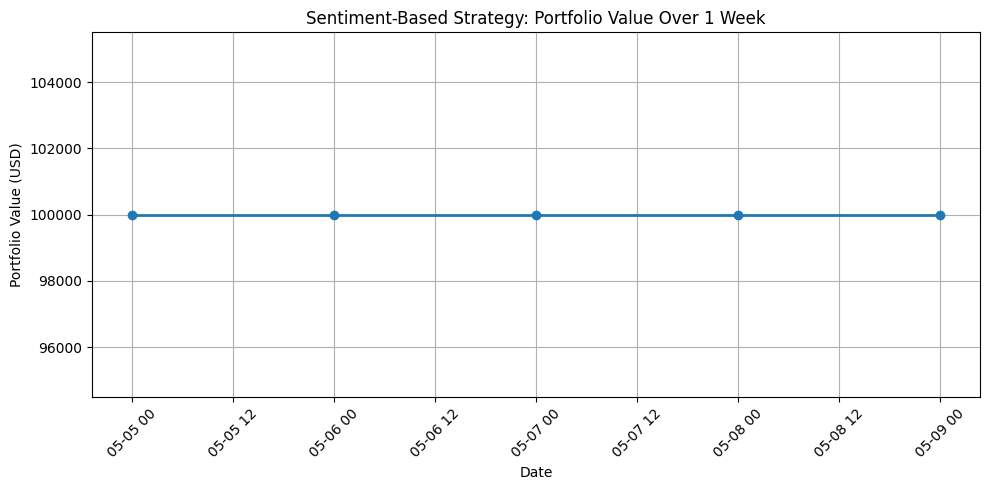

In [21]:
# Create DataFrame from strategy returns
df = pd.DataFrame(strategy_returns)

# Ensure correct data types
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['portfolio_value'] = pd.to_numeric(df['portfolio_value'], errors='coerce')

# Plot the portfolio value
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['portfolio_value'], marker='o', linewidth=2)
plt.title('Sentiment-Based Strategy: Portfolio Value Over 1 Week')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()